# Estimating COVID-19's $R_t$ in Real-Time

> Original code by Kevin Systrom - April 17 ( *translated into Julia by Hugh Murrell April 2020* )

> Simplification to direct computation of $R_t$ without Bayesian methods by Hugh Murrell May 2020


In any epidemic, $R_t$ is the measure known as the effective reproduction number. It's the number of people who become infected per infectious person at time $t$. The most well-known version of this number is the basic reproduction number: $R_0$ when $t=0$. However, $R_0$ is a single measure that does not adapt with changes in behavior and restrictions.

As a pandemic evolves, increasing restrictions (or potential releasing of restrictions) changes $R_t$. Knowing the current $R_t$ is essential. When $R\gg1$, the pandemic will spread through a large part of the population. If $R_t<1$, the pandemic will slow quickly before it has a chance to infect many people. The lower the $R_t$: the more manageable the situation. In general, any $R_t<1$ means things are under control.

The value of $R_t$ helps us in two ways. (1) It helps us understand how effective our measures have been controlling an outbreak and (2) it gives us vital information about whether we should increase or reduce restrictions based on our competing goals of economic prosperity and human safety. [Well-respected epidemiologists argue](https://www.nytimes.com/2020/04/06/opinion/coronavirus-end-social-distancing.html) that tracking $R_t$ is the only way to manage through this crisis.


### A frequentist approach

Read accompanying article.


In [1]:
using StatsBase, Distributions, Plots, DataFrames, CSV, Dates, HTTP, Impute, DSP;
# some model parameters that will be used throughout this notebook
IFP = 7   # infectious period in days
GAMMA = 1/IFP  # recovery rate
SMOOTHING_PASSES = 3 # number of times to apply moving average filter to case data
INF_CUTOFF = 0.02 # for detecting instability after pandemic has run its course
ONSET_DELAY = 4  # default onset delayin days, might get changed later
println("IFP=",IFP," GAMMA=",GAMMA," SMOOTHING_PASSES=",
    SMOOTHING_PASSES," INF_CUTOFF=",INF_CUTOFF," ONSET_DELAY=",ONSET_DELAY)

IFP=7 GAMMA=0.14285714285714285 SMOOTHING_PASSES=3 INF_CUTOFF=0.02 ONSET_DELAY=4


#### helper functions for applying onset-reporting delay

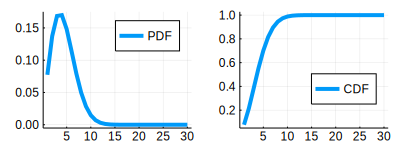

In [2]:
adj_range = collect(1:1:30)
p_delay = [pdf.(Weibull(2, 5),t) for t in adj_range]
p_delay = p_delay ./ sum(p_delay)
fig_weibull_pdf = plot(adj_range, p_delay, lw=4, label="PDF")
fig_weibull_cdf= plot(adj_range, cumsum(p_delay), lw=4, label="CDF",legend=:bottomright)
fig_weibull = plot(fig_weibull_pdf,fig_weibull_cdf,layout=(1,2),size=(400,150))
savefig("out/fig_weibull")
fig_weibull

In [3]:
ONSET_DELAY = findmax(p_delay)[2]

4

In [4]:
function estimate_onset(new_cases, p_delay)
    return reverse(conv(reverse(new_cases),p_delay))[length(p_delay):end]
end

estimate_onset (generic function with 1 method)

In [5]:
function adjust_onset(onset, p_delay)
    c_delay = cumsum(p_delay)
    extras = length(onset) - length(c_delay)
    if (extras > 0)
        cd = vcat(c_delay,ones(extras))
        adjusted = onset ./ reverse(cd)
    else
        adjusted = onset
    end
    return adjusted[1:end]
end

adjust_onset (generic function with 1 method)

#### helper functions for smoothing time series and stripping leading zero case counts

In [6]:
function moving_average(inf)
    vs = inf
    if length(vs) > 1
        ret = 
            vcat((vs[1]+2*vs[1])/3,
                   [sum(@view vs[i:(i+2)])/3 for i in 1:(length(vs)-(2))],
                    (2*vs[length(vs)]+vs[length(vs)])/3)
    else
        ret = vs
    end
    return ret
    return Int64.(round.(ret))
end

moving_average (generic function with 1 method)

In [7]:
function exponential_smoothing(seq; alpha=0.5)
    ss = copy(seq)
    for i in 2:length(ss)
        ss[i] = alpha * seq[i] + (1 - alpha)*ss[i-1]
    end
    return ss
end

exponential_smoothing (generic function with 1 method)

In [8]:
function compute_infectives(new_cases) 
    onset = estimate_onset(new_cases,p_delay)
    adj_onset = adjust_onset(onset,p_delay)
    if length(adj_onset) >= IFP
       infects = [sum(adj_onset[i-IFP+1:i])
                        for i in IFP:length(adj_onset) ] 
    else
        infects = []
    end
    return infects
end

compute_infectives (generic function with 1 method)

# Application to World Data

We load World case data from OWID in csv format using this link:
https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/ecdc/full_data.csv
and then we filter the data, country by country, removing sections with missing data or zero new case counts.

We need to start the analysis when there are a consistent number of cases each day. Find the last zero new case day and start on the day after that.

Also, case reporting is very erratic based on testing backlogs, etc. To get the best view of the 'true' data we apply a filter to the time series. The real world process is not nearly as stochastic as the actual reporting.

In [9]:
url="https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/ecdc/full_data.csv"
full_data = CSV.read(IOBuffer(HTTP.get(url).body))
println("table read, size = ",size(full_data))
println("latest counts on ",maximum(full_data[:,:date]))

table read, size = (19815, 6)
latest counts on 2020-05-27


#### helper function to apply onset correction to new_cases time series and then compute infectives

In [10]:
function strip_leading_zero_case_counts(data)
    nz = copy(data)
    nc = nz[:,:new_cases]
    ind = 1
    while (ind <= length(nc) && nc[ind]<=0)
        ind+=1
    end
    if (ind != 1)
        nz = copy(nz[ind:end,:])
    end
    return(nz)
end

strip_leading_zero_case_counts (generic function with 1 method)

In [11]:
function process_data(data)
    nz = copy(data[data[:,:date] .> Date(2020,2,23),:])
    sort!(nz,:date)
    nc = nz[:,:new_cases]
    nc[ismissing.(nc)] .= 0
    nz[:,:cases] = Float64.(cumsum(nc)) 
    allowmissing!(nz)
    # now insert missing dates and impute cumulative cases for those dates
    if size(nz)[1] > 1
        dr = nz[1,:date]:Day(1):nz[end,:date]
        for d in dr
            if ! (d in nz[:,:date])
                push!(nz,[missing for i in 1:size(nz)[2]])
                # nz[end,:location] = nz[end-1,:location]
                nz[end,:date] = d
            end
        end
        sort!(nz,:date)
        nz[!,:cases] = Impute.interp(nz[:,:cases])
    end
    smooth_new_cases = diff(nz[:,:cases])
    for i in 1:SMOOTHING_PASSES
        smooth_new_cases = moving_average(smooth_new_cases)
    end
    # nz[:,:new_cases] = Int64.(round.(smooth_new_cases))
    infectives = compute_infectives(smooth_new_cases)
    # remove first IFP data points for the 
    # and one more for the diff operator above
    pre_trim = size(nz)[1] - length(infectives)+1
    # nz = nz[IFP+1:end,:]
    nz = nz[pre_trim:end,:]
    # now insert infectives 
    nz[:,:infectives] = Float64.(infectives)
    # and post-trim by ONSET_DELAY, no dont
    # nz = nz[1:end-ONSET_DELAY,:]
    return nz   #[nz[:,:infectives].>0,:]
end

process_data (generic function with 1 method)

(87, 8)
min = 0 max = 11656 latest data at 2020-05-27 estimation at 2020-05-27


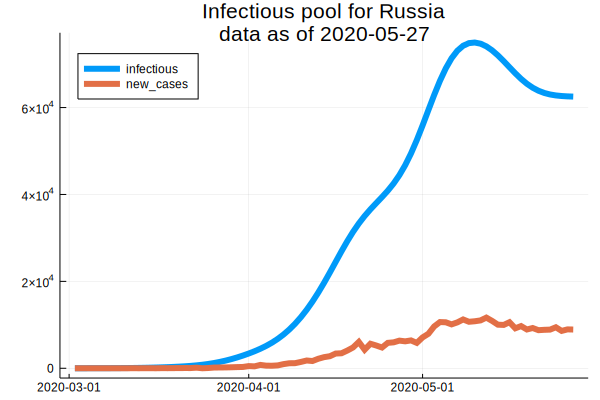

In [12]:
countries = unique(full_data[:,:location])
country = "Russia"
country_data = full_data[full_data[:,:location].==country,:]
data_date = maximum(country_data[:,:date])
country_data_filtered = process_data(country_data)
println(size(country_data_filtered))
est_date = country_data_filtered[:,:date][end]
println("min = ",minimum(country_data_filtered[:,:new_cases]), 
        " max = ",maximum(country_data_filtered[:,:new_cases]),
        " latest data at ",data_date, " estimation at ",est_date)
plot(country_data_filtered[:,:date], 
    [country_data_filtered[:,:infectives], country_data_filtered[:,:new_cases]], lw=6,
    legend=:topleft,
    labels=["infectious" "new_cases"],
    title="Infectious pool for $country \n data as of $data_date")

Putting all this into one function

In [13]:
function prepare_cases(full_data, country)
    country_data = full_data[full_data[:,:location].==country,:]
    country_data = strip_leading_zero_case_counts(country_data)
    if size(country_data)[1] < 30  # need at least one month of case counts
        return (country_data, false)
    end
    good_reporting = true # sum(country_data[:,:new_cases].==0)/length(country_data[:,:new_cases]) < 0
    sanity_check = good_reporting # && (minimum(country_data[:,:new_cases]) >= 0)
    country_data_filtered = process_data(country_data)
    # return (country_data_filtered[:,:date],country_data_filtered[:,:infectives], 
    #     country_data_filtered[:,:new_cases], sanity_check)
    return (country_data_filtered, sanity_check)
end

prepare_cases (generic function with 1 method)

sane = true


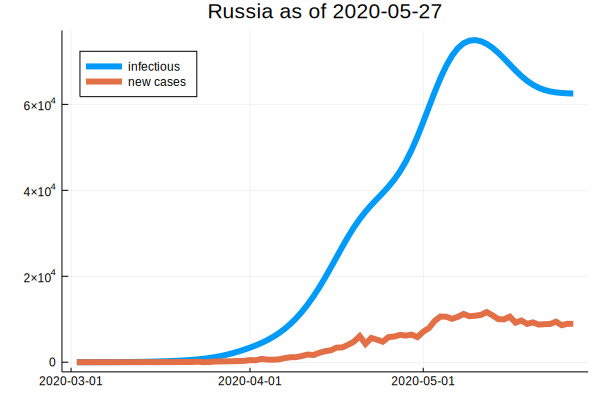

In [14]:
df,sane = prepare_cases(full_data,country)
println("sane = ",sane)
end_date = df[end,:date]
plot(df[:,:date], [df[:,:infectives], df[:,:new_cases]], lw=6,
    legend=:topleft,
    labels=["infectious" "new cases"],
    title="$country as of $end_date")

#### helper function to compute Rt estimates from Infectious counts.

In [15]:
function estimate_rt(data)
    infectives = data[:,:infectives]
    # instantaneous Rt estimate
    rt_est = [ 1 + IFP * ((infectives[i+1]-infectives[i])/(infectives[i])) 
                            for i in 1:length(infectives)-1]
    # apply low Rt cutoff 
    for i in 1:length(rt_est)
        max_inf = maximum(infectives[1:i])
        if (( infectives[i]/max_inf < INF_CUTOFF ) || rt_est[i]<0 )
            rt_est[i] = 0
        end
    end
    # sanity check
    sane = true
    last_week = rt_est[end-6:end]
    if maximum(last_week)-minimum(last_week) > 2
        sane = false
        println("something fishy...")
    end
    data = data[1:end-1,:]
    data[!,:rt_est] = rt_est
    # throw away the last ONSET_DELAY data
    data = data[1:end-ONSET_DELAY+1,:]
    return (data,sane)
end     

estimate_rt (generic function with 1 method)

#### Now lets try and produce latest Rt estimate for each country with enough case data

In [16]:
output_url = "../../HughMurrell.github.io/CoVmodel/RtLive/"
countries = unique(full_data[:,:location])
df = DataFrame(country=String[], start_date=Date[],end_date=Date[], est_date=Date[],
                    rt=Float64[],irat=Float64[],rank=Float64[])
for country in countries
    dc,sane = prepare_cases(full_data,country)
    if ( ! sane ) 
        println("skipping $country ... sanity check is $sane")
    else
        infectives = dc[:,:infectives]
        if ( length(infectives)<10 || maximum(infectives) < 400)
            println("skipping $country ... not enough data")
        else
            println("processing $country ...")
            start_date = dc[1,:date]  
            end_date = dc[end,:date]
            # calculate ratio of last I(t) to maximum of all I(t)s
            irat = round(infectives[end]/maximum(infectives),digits=2)
            inf_score = Int64(round(
                    100*(infectives[end]-infectives[end-ONSET_DELAY])/infectives[end-ONSET_DELAY],
                digits=0))
            up_down=""
            if inf_score > 0
                up_down = "up"
            else
                up_down = "down"
                inf_score = - inf_score
            end
            fig = plot(dc[:,:date], [dc[:,:infectives], dc[:,:new_cases]], lw=6,
                    legend=:topleft,
                    label=[ "infectious" "new_cases" ],
                    title="$country, infectious pool $inf_score% $up_down by $end_date")
            savefig(output_url*"plots/Inf_$country")
        
            # now use helpter to compute rt estimates
            dc,sane = estimate_rt(dc)
            if (! sane)
                println("skipping $country ... Rt estimation failed")
            else
                est_date = dc[end,:date]
                # make an Rt plot for this country
                rt_score = round(sum(dc[end,:rt_est]),digits=2)
            # cdf = DataFrame(date = dates[2:end], rt = rt_est)
                fig = plot(dc[:,:date], dc[:,:rt_est], 
                        lw = 3, label = "Rt estimate",
                        m=:circle, ms=6, ylimits=[-0.5,5.5],
                        title="$country, R(t) = $rt_score at $est_date")
                plot!(dc[:,:date], ones(size(dc)[1]),lw=3,label="R(t)=1")
                savefig(output_url*"plots/Rt_$country")
                # now save last mlrt, low, high, irat and rank
                rank = round(rt_score * irat, digits=2)
                push!(df,[country start_date end_date est_date rt_score irat rank])
            end
        end
    end
end
df

processing Afghanistan ...
skipping Albania ... not enough data
processing Algeria ...
skipping Andorra ... not enough data
skipping Angola ... not enough data
skipping Anguilla ... not enough data
skipping Antigua and Barbuda ... not enough data
processing Argentina ...
processing Armenia ...
skipping Aruba ... not enough data
processing Australia ...
processing Austria ...
processing Azerbaijan ...
skipping Bahamas ... not enough data
processing Bahrain ...
processing Bangladesh ...
skipping Barbados ... not enough data
processing Belarus ...
processing Belgium ...
skipping Belize ... not enough data
skipping Benin ... not enough data
skipping Bermuda ... not enough data
skipping Bhutan ... not enough data
processing Bolivia ...
skipping Bonaire Sint Eustatius and Saba ... not enough data
skipping Bosnia and Herzegovina ... not enough data
skipping Botswana ... not enough data
processing Brazil ...
skipping British Virgin Islands ... not enough data
skipping Brunei ... not enough dat

,country,start_date,end_date,est_date,rt,irat
,String,Date,Date,Date,Float64,Float64
1,Afghanistan,2020-03-03,2020-05-27,2020-05-23,1.29,1.0
2,Algeria,2020-03-04,2020-05-27,2020-05-23,1.05,1.0
3,Argentina,2020-03-11,2020-05-27,2020-05-23,1.28,1.0
4,Armenia,2020-03-08,2020-05-27,2020-05-23,1.18,0.99
5,Australia,2020-03-02,2020-05-27,2020-05-23,1.05,0.03
6,Austria,2020-03-04,2020-05-27,2020-05-23,0.85,0.05
7,Azerbaijan,2020-03-07,2020-05-27,2020-05-23,1.06,1.0
8,Bahrain,2020-03-02,2020-05-27,2020-05-23,0.81,0.81
9,Bangladesh,2020-03-16,2020-05-27,2020-05-23,0.98,0.91


In [17]:
dft = df
sort!(dft,:country)
CSV.write(output_url*"data/ranking_alpha.csv",dft)
sort!(dft,:rank)
CSV.write(output_url*"data/ranking_rtirat.csv",dft)
sort!(dft,:rt)
CSV.write(output_url*"data/ranking_rt.csv",dft)

"../../HughMurrell.github.io/CoVmodel/RtLive/data/ranking_rt.csv"

In [18]:
first(dft,6)

,country,start_date,end_date,est_date,rt,irat,rank
,String,Date,Date,Date,Float64,Float64,Float64
1,China,2020-03-02,2020-05-27,2020-05-23,0.0,0.01,0.0
2,Iceland,2020-03-07,2020-05-27,2020-05-23,0.0,0.0,0.0
3,New Zealand,2020-03-06,2020-05-27,2020-05-23,0.0,0.0,0.0
4,Thailand,2020-03-02,2020-05-27,2020-05-23,0.0,0.02,0.0
5,Zambia,2020-03-26,2020-05-27,2020-05-23,0.0,0.12,0.0
6,Croatia,2020-03-04,2020-05-27,2020-05-23,0.04,0.01,0.0


In [19]:
last(dft,6)

,country,start_date,end_date,est_date,rt,irat
,String,Date,Date,Date,Float64,Float64
1,Democratic Republic of Congo,2020-03-18,2020-05-27,2020-05-23,1.59,1.0
2,Malaysia,2020-03-02,2020-05-27,2020-05-23,2.15,0.83
3,South Sudan,2020-04-13,2020-05-27,2020-05-23,2.31,1.0
4,Sri Lanka,2020-03-02,2020-05-27,2020-05-23,2.53,1.0
5,Nicaragua,2020-03-26,2020-05-27,2020-05-23,3.13,1.0
6,Sao Tome and Principe,2020-04-16,2020-05-27,2020-05-23,3.41,1.0


In [20]:
maximum(dft[:,:end_date])

2020-05-27

In [21]:
maximum(dft[:,:est_date])

2020-05-23

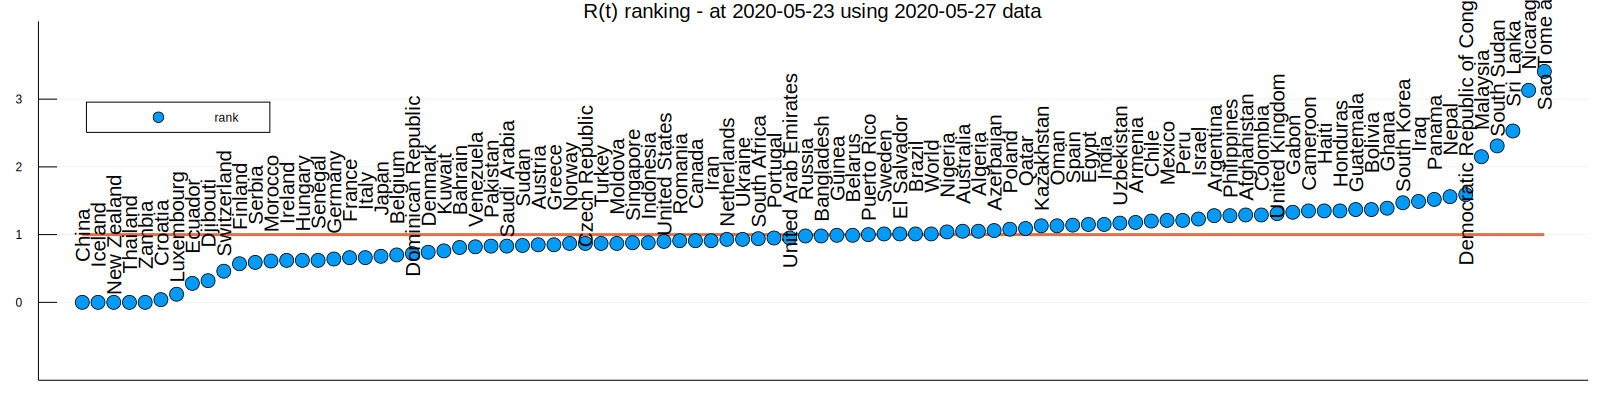

In [22]:
Plots.Font("sans-serif", 10, :hcenter, :center, 0.0, RGB(0.0,0.0,0.0))
myfont = text("").font
myfont.rotation = 90
est_date = maximum(dft[:,:est_date])
end_date = maximum(dft[:,:end_date])
fig = plot()
# fig = scatter( (dft[:,:high]+dft[:,:low])/2, 
#     yerror = (dft[:,:high]-dft[:,:low])/2, c=3,
#     m = :circle, ms = 0, markerstrokewidth = 2, label="")
plot!(ones(size(dft)[1]),label="",c=2, lw=3,    
    title="R(t) ranking - at $est_date using $end_date data")
scatter!(dft[:,:rt],markershape=:circle,   
    markersize = 8, c=1, 
    ylims=[-1, 4], yticks = [0.0, 1.0, 2.0, 3.0], xticks = [],
    # series_annotations=text.(dft[:,:country], :middle, 6, :hcenter, :vcenter),
    size=(1600,400),
    label="rank", legend=:topleft)
for j in 1:size(dft)[1]
    annotate!(j,dft[:,:rt][j]+1, dft[:,:country][j], myfont)
end
savefig("plots/ranking")
fig

# Application to South African provincial and national data

In [23]:
output_url = "../../HughMurrell.github.io/CoVmodel/RtLiveZA/"
url="https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv"
data = CSV.read(IOBuffer(HTTP.get(url).body),
            types=[String, String, Float64, Float64, Float64, Float64, Float64, 
                    Float64, Float64, Float64, Float64, Float64, Float64, String])
println(names(data))
date_format = DateFormat("dd-mm-yyyy")
data[!,:date] = Date.(data[:,:date],date_format)
data = data[:,[:date, :EC, :FS, :GP, :KZN, :LP, :MP, :NC, :NW, :WC, :total]]
dr = data[1,:date]:Day(1):data[end,:date]
for d in dr
    if ! (d in data[:,:date])
        push!(data,vcat(d, [missing for i in 1:size(data)[2]-2], 0))
    end
end
sort!(data)
data_date = data[end,:date]
est_date = data[end-ONSET_DELAY,:date]
println(data_date," ",est_date)
regions=names(data)[2:end]
rtdf = DataFrame(date=Date[], province=String[], infs=Int64[], rt=Float64[])
fig_inf = plot(legendtitle="latest count",legend=:topleft,ylabel="infectives",
    title="tracking infectives in South Africa\n using $data_date data")
fig_rts = plot(legendtitle="R estimate",legend=:bottomleft,ylabel="Rt", ylimits = [-1,4],
    title="tracking Rt in South Africa\n estimated at $est_date from $data_date data")
plot_count=0
rt_plots = []
inf_plots = []
for region in regions
    cases = Impute.interp(data[:,region])   # can impute on total cases (not on new-cases)
    new_cases = diff(cases)
    for i in 1:SMOOTHING_PASSES
        new_cases = moving_average(new_cases)
    end
    infectives = compute_infectives(new_cases)
    # infectives = [ cases[i]-cases[i-7] for i in 8:length(cases) ]
    # drop first IFP data points due to use of diff and infectives computation
    dates = data[IFP+1:end,:date]
    max_inf = maximum(infectives)
    if(max_inf<100)
        println("skipping ... ",region," max(inf) = ",max_inf)
    else
        println("processing ... ",region," max(inf) = ",max_inf)
        #deal with infectives first before losing end data points.
        inf_score = Int64(round(100*
                (infectives[end]-infectives[end-ONSET_DELAY])/
                infectives[end-ONSET_DELAY],digits=0))
        up_down=""
        if inf_score > 0
            up_down = "up"
        else
            up_down = "down"
            inf_score = - inf_score
        end
        if (region == :total)
            lab = "ZA $inf_score% $up_down"
        else
            lab = "$region $inf_score% $up_down"
        end
        inf_plot = plot(dates, infectives,lw=6,m=:circle,title=lab)
        inf_plots = vcat(inf_plots,[inf_plot])
        plot!(fig_inf, dates, infectives,lw=6,m=:circle,label=lab)
        rt_est = [ 1 + IFP * ((infectives[i+1]-infectives[i])/(infectives[i])) 
                            for i in 1:length(infectives)-1]
        # drop last date since todays rt estimates cannot be made till tomorrow
        dates = dates[1:end-1]
        # drop ONSET_DELAY-1 estimates from end of time series
        dates = dates[1:end-ONSET_DELAY+1]
        rt_est = rt_est[1:end-ONSET_DELAY+1]
        println(" estimation date = ",dates[end])
        for i in 1:length(dates)
            push!(rtdf,
            [dates[i] "$region" Int64(round(infectives[i])) rt_est[i] ]
            )
        end
        rt_score = round(last(rt_est),digits=2)
        if (region == :total)
            lab = "ZA $rt_score"
        else
            lab = "$region $rt_score"
        end
        rt_plot = plot(dates, rt_est, lw=6,m=:circle,title=lab,ylimits = [-1,3])
        rt_plots = vcat(rt_plots,[rt_plot])
        plot!(fig_rts, dates, rt_est, lw=6,m=:circle,label=lab)
        
        plot_count+=1
        # plot!(fig_inf, dates, infectives,lw=6,m=:circle,label=String(region))
    end
end
y = ones(3) 
panel_title_1 = Plots.scatter(y, marker=0,markeralpha=0, annotations=(2, y[2], 
        Plots.text(" Tracking Covid-19 in South Africa \n"* 
            "from $data_date data")),
        axis=false, leg=false,size=(200,100))
panel_title_2 = Plots.scatter(y, marker=0,markeralpha=0, annotations=(2, y[2], 
        Plots.text("Rt estimate \n at $est_date \n")),
        axis=false, leg=false,size=(200,100))
panel_title_3 = Plots.scatter(y, marker=0,markeralpha=0, annotations=(2, y[2], 
        Plots.text("Infectious pool movement \n over next $ONSET_DELAY days \n")),
        axis=false, leg=false,size=(200,100))
panel_title_23 = plot(panel_title_2,panel_title_3, 
    layout=grid(1,2)
)
println("plot count = ",plot_count)
l = @layout [ a b
              c d
              e f
              g h
              i j ]
panel_plot = plot(rt_plots[1], inf_plots[1],
    rt_plots[2], inf_plots[2],
    rt_plots[3], inf_plots[3],
    rt_plots[4], inf_plots[4],
    rt_plots[5], inf_plots[5],
    layout=l,legend=false,size=(600, 800))
titled_panel_plot = plot(panel_title_1,panel_title_23, panel_plot,
    layout=grid(3,1,heights=[0.05,0.05,0.9])
)
savefig(titled_panel_plot,output_url*"plots/PanelPlotZA")
savefig(fig_rts,output_url*"plots/RtLiveZA")
savefig(fig_inf,output_url*"plots/InfLiveZA")
CSV.write(output_url*"plots/provincial_rts.csv",rtdf)

Symbol[:date, :YYYYMMDD, :EC, :FS, :GP, :KZN, :LP, :MP, :NC, :NW, :WC, :UNKNOWN, :total, :source]
2020-05-26 2020-05-22
processing ... EC max(inf) = 780.9494442747764
 estimation date = 2020-05-22
skipping ... FS max(inf) = 50.70577277512967
processing ... GP max(inf) = 589.5174023722394
 estimation date = 2020-05-22
processing ... KZN max(inf) = 314.84052202611133
 estimation date = 2020-05-22
skipping ... LP max(inf) = 50.35438916268609
skipping ... MP max(inf) = 25.254988969146744
skipping ... NC max(inf) = 7.777596358255456
skipping ... NW max(inf) = 45.339691473821745
processing ... WC max(inf) = 5102.9916684034115
 estimation date = 2020-05-22
processing ... total max(inf) = 6785.4844256028855
 estimation date = 2020-05-22
plot count = 5


"../../HughMurrell.github.io/CoVmodel/RtLiveZA/plots/provincial_rts.csv"

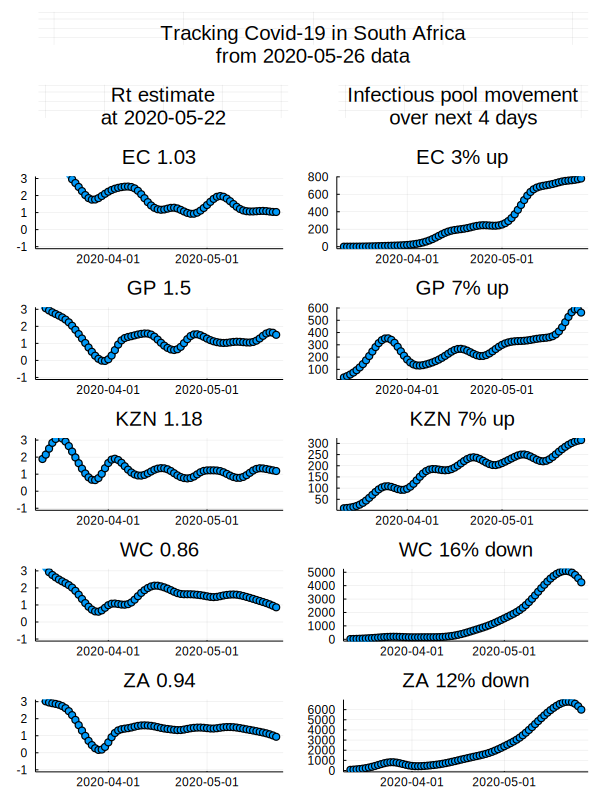

In [24]:
titled_panel_plot

In [25]:
panel_plot_za = plot(rt_plots[5], inf_plots[5], layout=(1,2), 
    title=["R scores till $est_date" "I counts till $data_date"],
size=(600,200))
savefig(panel_plot_za,output_url*"plots/fig_rt_inf_za")

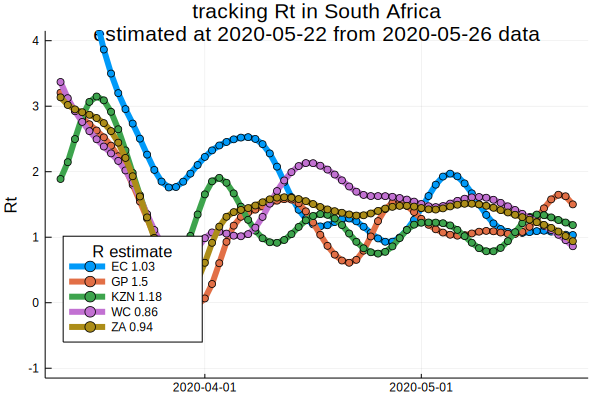

In [26]:
fig_rts

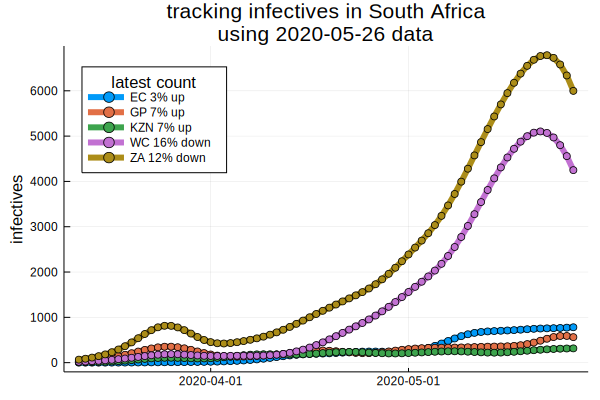

In [27]:
fig_inf

In [28]:
output_url = "../../HughMurrell.github.io/CoVmodel/RtLiveZA/"
url="https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv"
data = CSV.read(IOBuffer(HTTP.get(url).body),
            types=[String, String, Float64, Float64, Float64, Float64, Float64, 
                    Float64, Float64, Float64, Float64, Float64, Float64, String])
date_format = DateFormat("dd-mm-yyyy")
data[!,:date] = Date.(data[:,:date],date_format)
data = data[:,[:date, :EC, :FS, :GP, :KZN, :LP, :MP, :NC, :NW, :WC, :total]]
dr = data[1,:date]:Day(1):data[end,:date]
for d in dr
    if ! (d in data[:,:date])
        push!(data,vcat(d, [missing for i in 1:size(data)[2]-2], 0))
    end
end
sort!(data)
data_date = maximum(data[:,:date])
regions=names(data)[2:end]
region = :total
fig_inf = plot(legend=:topleft,ylabel="infectious",
    title="tracking infectives in South Africa, $region \n from $data_date data")
fig_rts = plot(legendtitle="latest R from:",legend=:topright,ylabel="R(t)", ylimits = [-1,4],
    title="tracking R(t) in South Africa, $region \n from $data_date data")
cases = Impute.interp(data[:,region])   # can impute on total cases (not on new-cases)
println("no of data points = ",length(cases))
infectives = [ cases[i]-cases[i-IFP] for i in IFP+2:length(cases) ]

onset = estimate_onset(diff(cases),p_delay)
adj_onset = adjust_onset(onset,p_delay)
adj_cases = cumsum(adj_onset)
adj_infectives = [ adj_cases[i]-adj_cases[i-IFP] for i in 8:length(adj_cases) ]
# drop the first IFP and the last ONSET_DELAY data points because onset alg looses them
dates = data[IFP:end-ONSET_DELAY-2,:date]  
est_date = maximum(dates)
max_inf = maximum(infectives)
println("processing ... ",region," max(inf) = ",max_inf)
for i in 1:SMOOTHING_PASSES
    infectives = moving_average(infectives)
end
rt_est = [ 1 + IFP * ((infectives[i+1]-infectives[i])/infectives[i]) 
                            for i in 1:length(infectives)-1]
# drop the first few data points to shift the crude est back in time
rt_est = rt_est[ONSET_DELAY:end]  
infectives = infectives[ONSET_DELAY+1:end]  
adj_rt_est = [ 1 + IFP * ((adj_infectives[i+1]-adj_infectives[i])/adj_infectives[i]) 
                            for i in 1:length(adj_infectives)-1]
adj_rt_est = adj_rt_est[1:end-ONSET_DELAY+1]
adj_infectives = adj_infectives[1:end-ONSET_DELAY]  
exp_smooth_rts = exponential_smoothing(adj_rt_est,alpha=0.5)

est_score = round(rt_est[end],digits=2)
adj_score = round(adj_rt_est[end],digits=2)
exp_score = round(exp_smooth_rts[end],digits=2)
count = Int64(round(infectives[end],digits=0))
println(length(dates))
println(length(rt_est))
println(length(adj_rt_est))
println(length(infectives))
println(length(adj_infectives))
plot!(fig_rts, dates, rt_est, lw=6,m=:circle,label="left shifted Rt $est_score")
plot!(fig_rts, dates, adj_rt_est, lw=6,m=:circle,label="onset adj Rt $adj_score",
        legendtitle="R(t) at $est_date")
# plot!(fig_rts, dates, exp_smooth_rts, lw=6,m=:circle,label="exp smooth onset $exp_score")
plot!(fig_inf, dates, infectives,lw=6,m=:circle,label="shifted infectives")
plot!(fig_inf, dates, adj_infectives,lw=6,m=:circle,label="onset adjusted",
        legendtitle="I(t) at $est_date")
   # plot!(fig_inf, dates, adj_smooth_inf,lw=6,m=:circle,label="adjusted")
savefig(fig_rts,output_url*"plots/RtLiveZAtotal")
savefig(fig_inf,output_url*"plots/InfLiveZAtotal")

no of data points = 83
processing ... total max(inf) = 7182.0
71
71
71
71
71


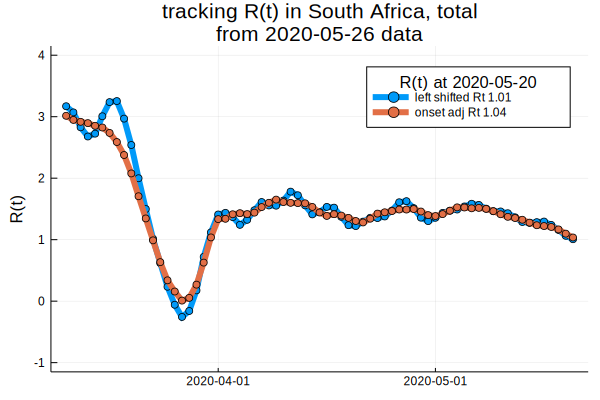

In [29]:
fig_rts

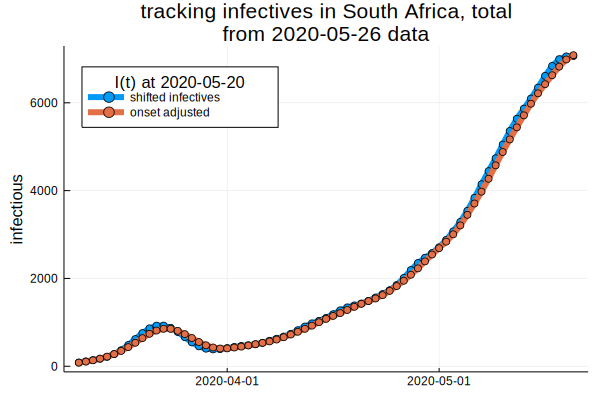

In [30]:
fig_inf